<a href="https://colab.research.google.com/github/monolixd/Covid19-lungs-infectedCNN/blob/main/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
import random

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import classification_report

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

In [3]:
set_seed()

Random seed set as 42


# Hyperparameters

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 3e-4
NUM_EPOCH = 30
STEP_SIZE = 10
GAMMA = 0.5

In [5]:
transform = tt.Compose([
    tt.ToTensor(),
    tt.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    tt.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])])

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 158M/158M [00:01<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


In [7]:
# Path ของ Train และ Test
train_path = "/root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train"
test_path = "/root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/test"

data_test = ImageFolder(test_path, transform=transform)
data_train = ImageFolder(train_path, transform=transform)

In [8]:
import os

# หมวดหมู่ข้อมูล
categories = ["Covid", "Normal", "Viral Pneumonia"]

# ฟังก์ชันนับจำนวนไฟล์ในแต่ละคลาส
def count_images_in_categories(base_path, categories):
    for category in categories:
        category_path = os.path.join(base_path, category)
        print(f"{category}: {len(os.listdir(category_path))} images")

# ตรวจสอบ Train
print("Train Data:")
count_images_in_categories(train_path, categories)

# ตรวจสอบ Test
print("\nTest Data:")
count_images_in_categories(test_path, categories)

Train Data:
Covid: 111 images
Normal: 70 images
Viral Pneumonia: 70 images

Test Data:
Covid: 26 images
Normal: 20 images
Viral Pneumonia: 20 images


# CUDA CHECK

In [9]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [10]:
train_loader = DataLoader(data_train,batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, drop_last=True)

# ประเมินผลโมเดล

In [11]:
def model_eval(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    num_batches = len(loader)

    with torch.no_grad():
        for img, label in loader:
            out = model(img)
            loss = loss_fn(out, label)

            acc_ =(((out==label.argmax(1)).int().sum())/len(out)).item()
            total_loss += loss.item()
            total_acc += acc_

    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches

    model.train()
    return avg_acc, avg_loss

# AlexNet model

## สร้างโมเดล CNN (Convolutional Neural Network) ด้วย PyTorch

In [15]:
class CNN(nn.Module):
    def __init__(self,inp_ch, out_ch):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=96, kernel_size=(11,11), stride=4),
            nn.ReLU(),
            nn.BatchNorm2d(96))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5,5), padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            )

        self.detect_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*2*2, out_features=out_ch),
            nn.Softmax(dim=1)
        )


        self.Maxpool = nn.MaxPool2d(kernel_size=(3,3),stride=2)

    def forward(self,img):
        img = self.Maxpool(img)

        img = self.conv1(img)
        img = self.Maxpool(img)

        img = self.conv2(img)
        img = self.Maxpool(img)

        img = self.conv3(img)
        img = self.Maxpool(img)

        pred = self.detect_layer(img)

        return pred

In [16]:
def train_model(model, optimizer, Loss_fn, scheduler, NUM_EPOCH=NUM_EPOCH, device=device):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(NUM_EPOCH):
        model.train()
        loss_epoch = 0
        acc_train = 0

        for img, label in tqdm(train_loader):
            img = img.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            out = model(img)
            loss = Loss_fn(out, label)
            loss_epoch += loss.item()

            loss.backward()
            optimizer.step()

            preds = out.argmax(dim=1)
            acc_train += (preds == label).sum().item()

        scheduler.step()
        avg_train_loss = loss_epoch / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_acc = acc_train / len(train_loader.dataset)
        train_acc_list.append(train_acc)

        #eval
        model.eval()
        loss_test_epoch = 0
        acc_test = 0

        with torch.no_grad():
            for img, label in test_loader:

                img = img.to(device)
                label = label.to(device)
                out = model(img)
                loss = Loss_fn(out, label)
                loss_test_epoch += loss.item()

                preds = out.argmax(dim=1)
                acc_test += (preds == label).sum().item()

        avg_test_loss = loss_test_epoch / len(test_loader)
        test_loss_list.append(avg_test_loss)
        test_acc = acc_test / len(test_loader.dataset)
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch + 1}/{NUM_EPOCH}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Train Acc = {train_acc:.4f}, "
              f"Test Loss = {avg_test_loss:.4f}, "
              f"Test Acc = {test_acc:.4f}")

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [17]:
def show_img(model, device=device):
    ig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
    index = 0

    model.cpu()
    model.eval()
    with torch.no_grad():
        for i in range(3):
            for j in range(3):
                index = np.random.randint(len(data_test))
                img = data_test[index][0]
                label = data_test[index][1]
                pred = model(img.unsqueeze(0)).argmax().item()
                axes[i][j].imshow(img.permute(1, 2, 0).numpy())
                axes[i][j].set_title(f"Pred: {pred}\nLabel: {label}", fontsize=12)
                axes[i][j].axis('off')
    model.to(device)
    plt.tight_layout()
    plt.show()

In [18]:
class Model:
    def __init__(self, model, device=device):
        self.model = model.to(device)
        self.optimizer = Adam(self.model.parameters(), lr = LR )
        self.Loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    def __call__(self, img):
        if len(img.size()) == 3:
            return self.model(img.unsqueeze(0)).squeeze(0)
        return self.model(img)

    def metrics(self, loader):

        pred_list = []
        label_list = []

        with torch.no_grad():
            self.model.eval()
            for img, label in loader:

                img = img.to(device)
                label = label.to(device)

                out = self.model(img)
                pred_list.extend( out.argmax(1).tolist() )
                label_list.extend( label.tolist())

            self.model.train()
        print(classification_report(pred_list, label_list, zero_division=0))

    def train(self):
        train_loss_list, test_loss_list, train_acc_list, test_acc_list = train_model(model=self.model,
                                                                         optimizer=self.optimizer,
                                                                         Loss_fn=self.Loss_fn,
                                                                         scheduler=self.scheduler)

        plt.subplot(1, 2, 1)
        plt.plot(range(1, NUM_EPOCH + 1), train_loss_list, marker='o', label='Train Loss')
        plt.plot(range(1, NUM_EPOCH + 1), test_loss_list, marker='o', label='Test Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, NUM_EPOCH + 1), train_acc_list, marker='o', label='Train Accuracy', color='blue')
        plt.plot(range(1, NUM_EPOCH + 1), test_acc_list, marker='o', label='Test Accuracy', color='orange')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

    def eval(self):
        self.model.eval()

    def cpu(self):
        self.model.cpu()

    def to(self, device):
        self.model.to(device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 0.8206, Train Acc = 0.6653, Test Loss = 0.8856, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 0.7062, Train Acc = 0.7968, Test Loss = 0.8601, Test Acc = 0.6667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 0.7055, Train Acc = 0.8048, Test Loss = 0.7054, Test Acc = 0.8788


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.6805, Train Acc = 0.8327, Test Loss = 0.7929, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.6650, Train Acc = 0.8446, Test Loss = 0.7233, Test Acc = 0.8636


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.6604, Train Acc = 0.8486, Test Loss = 0.7252, Test Acc = 0.8333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.6488, Train Acc = 0.8606, Test Loss = 0.6710, Test Acc = 0.9091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30: Train Loss = 0.6433, Train Acc = 0.8685, Test Loss = 0.7107, Test Acc = 0.8636


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30: Train Loss = 0.6275, Train Acc = 0.8884, Test Loss = 0.6675, Test Acc = 0.9091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30: Train Loss = 0.6343, Train Acc = 0.8765, Test Loss = 0.7266, Test Acc = 0.8333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30: Train Loss = 0.6383, Train Acc = 0.8725, Test Loss = 0.6630, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30: Train Loss = 0.6234, Train Acc = 0.8884, Test Loss = 0.6690, Test Acc = 0.9091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30: Train Loss = 0.6266, Train Acc = 0.8845, Test Loss = 0.6752, Test Acc = 0.9091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30: Train Loss = 0.6230, Train Acc = 0.8884, Test Loss = 0.6647, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30: Train Loss = 0.6195, Train Acc = 0.8924, Test Loss = 0.6579, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30: Train Loss = 0.6226, Train Acc = 0.8884, Test Loss = 0.6527, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30: Train Loss = 0.6223, Train Acc = 0.8884, Test Loss = 0.6499, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30: Train Loss = 0.6220, Train Acc = 0.8884, Test Loss = 0.6507, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30: Train Loss = 0.6225, Train Acc = 0.8884, Test Loss = 0.6548, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30: Train Loss = 0.6221, Train Acc = 0.8884, Test Loss = 0.6551, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30: Train Loss = 0.6222, Train Acc = 0.8884, Test Loss = 0.6548, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30: Train Loss = 0.6221, Train Acc = 0.8884, Test Loss = 0.6545, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30: Train Loss = 0.6222, Train Acc = 0.8884, Test Loss = 0.6542, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30: Train Loss = 0.6220, Train Acc = 0.8884, Test Loss = 0.6544, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30: Train Loss = 0.6218, Train Acc = 0.8884, Test Loss = 0.6552, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30: Train Loss = 0.6219, Train Acc = 0.8884, Test Loss = 0.6543, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30: Train Loss = 0.6224, Train Acc = 0.8884, Test Loss = 0.6545, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30: Train Loss = 0.6221, Train Acc = 0.8884, Test Loss = 0.6563, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30: Train Loss = 0.6218, Train Acc = 0.8884, Test Loss = 0.6569, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30: Train Loss = 0.6220, Train Acc = 0.8884, Test Loss = 0.6561, Test Acc = 0.9242


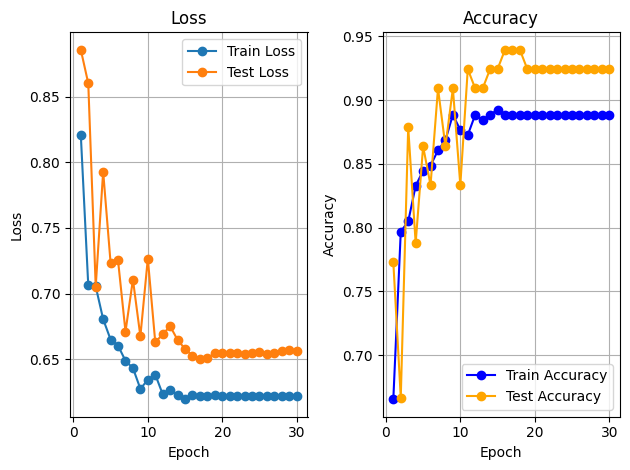

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.91      0.95        22
           2       0.94      0.94      0.94        18

    accuracy                           0.95        64
   macro avg       0.96      0.95      0.95        64
weighted avg       0.96      0.95      0.95        64



In [19]:
Alex_Net = Model(CNN(3,3))
Alex_Net.train()
Alex_Net.metrics(test_loader)

# ResNet

🔎 ฟีเจอร์สำคัญของโค้ดนี้<br>
✅ ใช้โมเดลที่เรียนรู้มาแล้ว (pretrained=True) → ไม่ต้องฝึกใหม่ทั้งหมด<br>
✅ ปรับเฉพาะ Fully Connected Layer (fc) เพื่อให้จำแนก 3 คลาส<br>
✅ Transfer Learning ช่วยลดเวลาและพลังงานที่ใช้ฝึกโมเดล<br>

In [20]:
resnet18_v1 = models.resnet18(pretrained=True)
resnet18_v1.fc = nn.Linear(resnet18_v1.fc.in_features, 3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 0.5483, Train Acc = 0.7530, Test Loss = 1.4293, Test Acc = 0.6364


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 0.3653, Train Acc = 0.8845, Test Loss = 0.4318, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 0.3534, Train Acc = 0.8765, Test Loss = 0.3967, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.3424, Train Acc = 0.8805, Test Loss = 0.3495, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.3202, Train Acc = 0.8884, Test Loss = 0.3399, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.3145, Train Acc = 0.8924, Test Loss = 0.3515, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.3057, Train Acc = 0.8924, Test Loss = 0.3291, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30: Train Loss = 0.2996, Train Acc = 0.8924, Test Loss = 0.3287, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30: Train Loss = 0.2985, Train Acc = 0.8924, Test Loss = 0.3433, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30: Train Loss = 0.3053, Train Acc = 0.8924, Test Loss = 0.3230, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30: Train Loss = 0.3008, Train Acc = 0.8924, Test Loss = 0.3393, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30: Train Loss = 0.2984, Train Acc = 0.8924, Test Loss = 0.3440, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30: Train Loss = 0.3003, Train Acc = 0.8924, Test Loss = 0.3344, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30: Train Loss = 0.2951, Train Acc = 0.8924, Test Loss = 0.3318, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30: Train Loss = 0.2974, Train Acc = 0.8924, Test Loss = 0.3404, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30: Train Loss = 0.3022, Train Acc = 0.8924, Test Loss = 0.3355, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30: Train Loss = 0.2967, Train Acc = 0.8924, Test Loss = 0.3346, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30: Train Loss = 0.3036, Train Acc = 0.8924, Test Loss = 0.3615, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30: Train Loss = 0.3012, Train Acc = 0.8924, Test Loss = 0.3286, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30: Train Loss = 0.2983, Train Acc = 0.8924, Test Loss = 0.3418, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30: Train Loss = 0.2990, Train Acc = 0.8924, Test Loss = 0.3413, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30: Train Loss = 0.2955, Train Acc = 0.8924, Test Loss = 0.3433, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30: Train Loss = 0.2960, Train Acc = 0.8924, Test Loss = 0.3370, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30: Train Loss = 0.2959, Train Acc = 0.8924, Test Loss = 0.3363, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30: Train Loss = 0.2949, Train Acc = 0.8924, Test Loss = 0.3361, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30: Train Loss = 0.2947, Train Acc = 0.8924, Test Loss = 0.3414, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30: Train Loss = 0.2956, Train Acc = 0.8924, Test Loss = 0.3381, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30: Train Loss = 0.2978, Train Acc = 0.8924, Test Loss = 0.3352, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30: Train Loss = 0.2963, Train Acc = 0.8924, Test Loss = 0.3456, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30: Train Loss = 0.2944, Train Acc = 0.8924, Test Loss = 0.3514, Test Acc = 0.9545


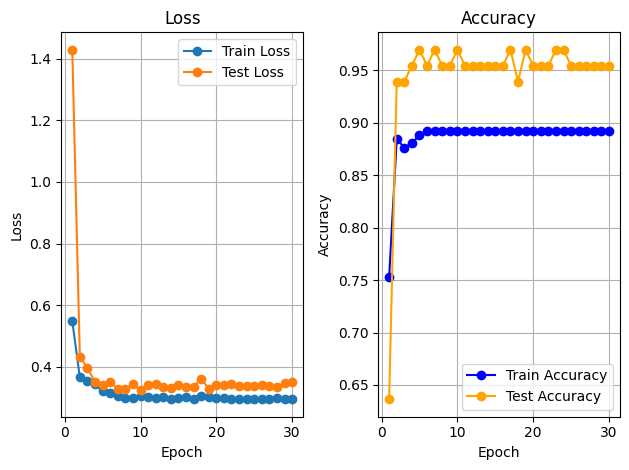

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.95      1.00      0.97        19
           2       1.00      0.95      0.97        19

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64



In [21]:
ResNet18_v1 = Model(resnet18_v1)
ResNet18_v1.train()
ResNet18_v1.metrics(test_loader)

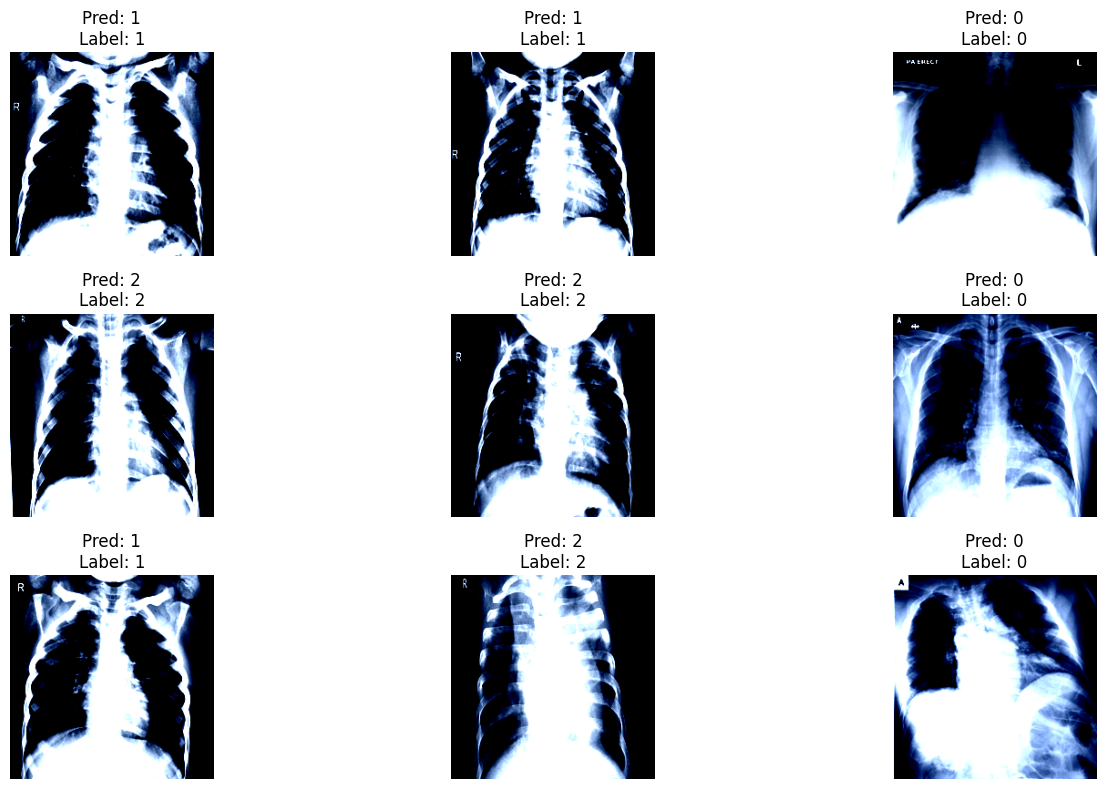

In [28]:
show_img(ResNet18_v1)

## unfreeze 2 layers

In [23]:
def freeze_layers(model, num_layers: int):
    for param in model.parameters():
        param.requires_grad = False

    params = list(model.parameters())

    for param in params[-num_layers:]:
        param.requires_grad = True

In [24]:
resnet18_v2 = models.resnet18(pretrained=True)
resnet18_v2.fc = nn.Linear(resnet18_v2.fc.in_features, 3)
freeze_layers(resnet18_v2, 3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 1.0409, Train Acc = 0.4462, Test Loss = 1.2730, Test Acc = 0.3939


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 0.9684, Train Acc = 0.5299, Test Loss = 1.2326, Test Acc = 0.3939


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 0.8854, Train Acc = 0.6414, Test Loss = 1.2099, Test Acc = 0.4091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.8309, Train Acc = 0.6494, Test Loss = 1.1673, Test Acc = 0.4091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.7741, Train Acc = 0.6972, Test Loss = 1.0408, Test Acc = 0.4545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.7285, Train Acc = 0.7610, Test Loss = 1.0159, Test Acc = 0.4394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.6930, Train Acc = 0.7729, Test Loss = 0.9551, Test Acc = 0.5303


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30: Train Loss = 0.6742, Train Acc = 0.7888, Test Loss = 0.8723, Test Acc = 0.5303


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30: Train Loss = 0.6428, Train Acc = 0.7928, Test Loss = 0.8014, Test Acc = 0.6667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30: Train Loss = 0.6340, Train Acc = 0.7888, Test Loss = 0.7517, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30: Train Loss = 0.6067, Train Acc = 0.8367, Test Loss = 0.7326, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30: Train Loss = 0.5717, Train Acc = 0.8247, Test Loss = 0.7193, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30: Train Loss = 0.5942, Train Acc = 0.8048, Test Loss = 0.7058, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30: Train Loss = 0.5803, Train Acc = 0.8247, Test Loss = 0.6976, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30: Train Loss = 0.5660, Train Acc = 0.8207, Test Loss = 0.6912, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30: Train Loss = 0.5610, Train Acc = 0.8367, Test Loss = 0.6825, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30: Train Loss = 0.5378, Train Acc = 0.8287, Test Loss = 0.6816, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30: Train Loss = 0.5433, Train Acc = 0.8247, Test Loss = 0.6774, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30: Train Loss = 0.5442, Train Acc = 0.8207, Test Loss = 0.6665, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30: Train Loss = 0.5418, Train Acc = 0.8207, Test Loss = 0.6622, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30: Train Loss = 0.5685, Train Acc = 0.8008, Test Loss = 0.6605, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30: Train Loss = 0.5415, Train Acc = 0.8207, Test Loss = 0.6582, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30: Train Loss = 0.5328, Train Acc = 0.8247, Test Loss = 0.6536, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30: Train Loss = 0.5224, Train Acc = 0.8367, Test Loss = 0.6545, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30: Train Loss = 0.5318, Train Acc = 0.8127, Test Loss = 0.6517, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30: Train Loss = 0.5124, Train Acc = 0.8327, Test Loss = 0.6502, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30: Train Loss = 0.5168, Train Acc = 0.8446, Test Loss = 0.6475, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30: Train Loss = 0.5316, Train Acc = 0.8167, Test Loss = 0.6440, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30: Train Loss = 0.5375, Train Acc = 0.8127, Test Loss = 0.6408, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30: Train Loss = 0.5054, Train Acc = 0.8446, Test Loss = 0.6436, Test Acc = 0.7576


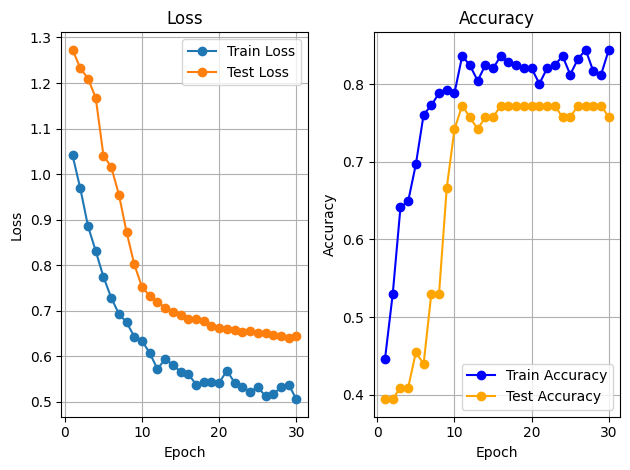

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.55      0.92      0.69        12
           2       0.72      0.59      0.65        22

    accuracy                           0.78        64
   macro avg       0.76      0.79      0.76        64
weighted avg       0.82      0.78      0.79        64



In [25]:
ResNet18_v2 = Model(resnet18_v2)
ResNet18_v2.train()
ResNet18_v2.metrics(test_loader)

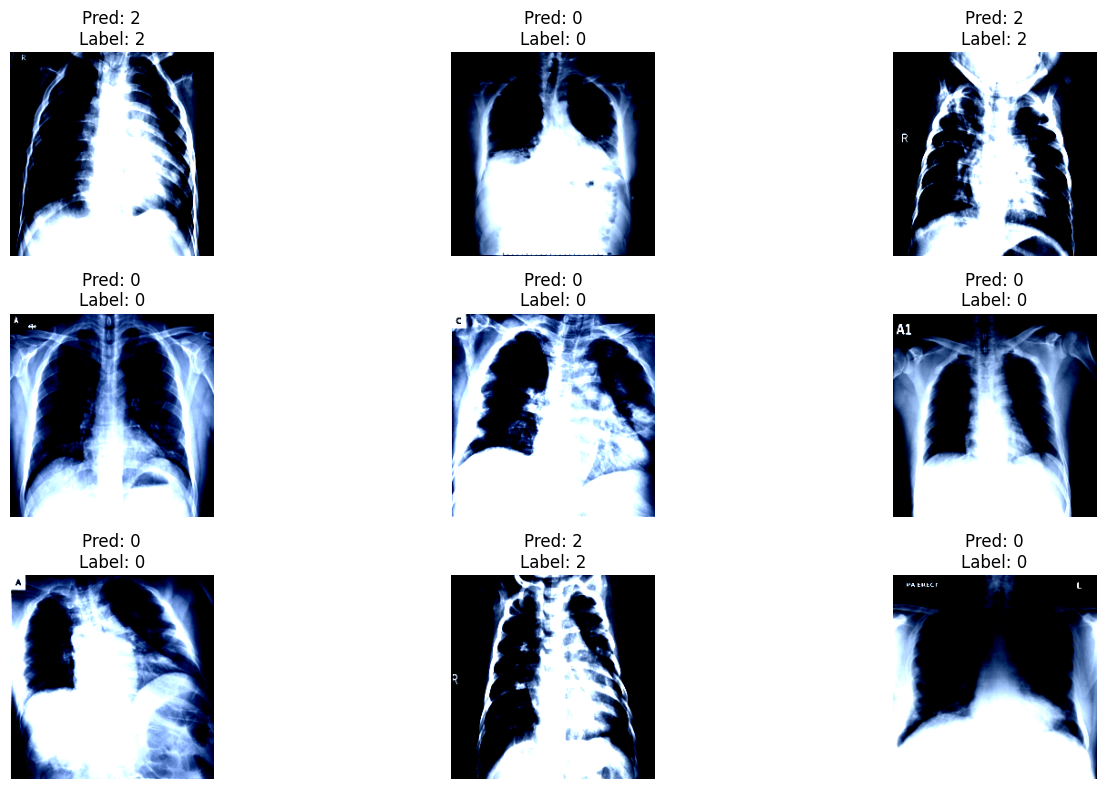

In [27]:
show_img(ResNet18_v2)